# Inhibitors selection


In [ ]:
# Import necessary libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Draw
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from rdkit import RDLogger
from rdkit.Chem import AllChem, QED, RDConfig, Lipinski, Descriptors

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin

from tqdm import tqdm

import os, sys, pickle
from rdkit.Chem import AllChem, QED, RDConfig, Lipinski, Descriptors
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
from scipy import stats
import scikit_posthocs as sp

# Functions

In [ ]:
# Drug-like properties

def check_qed(mol):
  """ Calculates QED-score """
  return QED.qed(mol)

def check_sascore(mol):
  """ Calculates SAScore """
  return sascorer.calculateScore(mol)

def check_lipinski_ro5(mol):
  """ Checks Lipinski's rule of five for drig-like molecules """
  counter = 0
  counter += 1 if Chem.Lipinski.NumHDonors(mol) <= 5 else 0
  counter += 1 if Chem.Lipinski.NumHAcceptors(mol) <= 10 else 0
  counter += 1 if Chem.Descriptors.MolWt(mol) <= 500 else 0
  counter += 1 if Chem.Descriptors.MolLogP(mol) <= 5 else 0

  return counter >= 3

tox_df = pd.read_csv('/content/drive/MyDrive/models/tox_alerts.txt', sep='\t')
def check_toxicophore(mol):
  """ Returns the number of toxicophore groups in a molecule """
  count = 0
  for smarts in tox_df.SMARTS.to_list():
    pattern = Chem.MolFromSmarts(smarts)
    if mol.HasSubstructMatch(pattern)==True:
      count += 1
  return count

In [ ]:
RDLogger.DisableLog('rdApp.*')

def validate_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

# Generation by basic FREED++

In [ ]:
class pIC_predictor(BaseEstimator, TransformerMixin):
    def __init__(self, predictor_path, radius=2, fpSize=2048):
        self.predictor = joblib.load(predictor_path)
        self.radius = radius
        self.fpSize = fpSize

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['fingerprints'] = X.Smiles.apply(self.get_fingerprint)
        new_fingerprints = np.vstack(X['fingerprints'].values)
        new_fingerprint_columns = [f'fingerprint_{i}' for i in range(new_fingerprints.shape[1])]
        new_fingerprint_df = pd.DataFrame(new_fingerprints, columns=new_fingerprint_columns)
        X = pd.concat([X, new_fingerprint_df], axis=1)
        X = X.drop('fingerprints', axis=1)
        X['pIC50'] = self.predictor.predict(X[new_fingerprint_columns])
        columns_to_keep = ['Smiles', 'DockingScoreProperty', 'pIC50', 'QED', 'sascore', 'lipinski_ro5',
                           'tox_groups', 'Epoch']
        X = X[columns_to_keep]
        return X

    def get_fingerprint(self, smiles):
        mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=self.radius, fpSize=self.fpSize)
        mol = Chem.MolFromSmiles(smiles)
        fp = mfpgen.GetFingerprintAsNumPy(mol)
        return fp

In [ ]:
def process_dataset(file_path, predictor_path):

    # Data reading
    df = pd.read_csv(file_path)

    # Validation of Smiles
    df['IsValidSmiles'] = df['Smiles'].apply(validate_smiles)
    df = df[df['IsValidSmiles'] == True]
    df.reset_index(drop=True, inplace=True)
    df = df.drop('IsValidSmiles', axis=1)

    # Removing duplicates
    df.drop_duplicates(subset='Smiles', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Drug-like propeties
    df['mol'] = df.Smiles.apply(Chem.MolFromSmiles)
    df['QED'] = df.mol.apply(check_qed)
    df['sascore'] = df.mol.apply(check_sascore)
    df['lipinski_ro5'] = df.mol.apply(check_lipinski_ro5)
    df['tox_groups'] = df.mol.apply(check_toxicophore)

    # Bioactivity prediction
    bioactivity_predictor = pIC_predictor(predictor_path)
    df = bioactivity_predictor.transform(df)

    return df

In [ ]:
predictor_path = '/content/drive/MyDrive/статья/Models/stacking_regressor.joblib'

In [ ]:
datasets = [
    '/content/drive/MyDrive/статья/Mols/Base_FREED++.csv',
    '/content/drive/MyDrive/статья/Mols/Basic_Starting_fragment_A.csv',
    '/content/drive/MyDrive/статья/Mols/Basic_Starting_fragment_B.csv'
]

results = []

In [ ]:
for dataset in tqdm(datasets, desc="Processing datasets"):
    result = process_dataset(dataset, predictor_path)
    results.append(result)

exp_1, exp_3, exp_5 = results

Processing datasets: 100%|██████████| 3/3 [05:55<00:00, 118.47s/it]


# Generation with modified reward function

In [ ]:
def process_dataset(file_path):
    # Data reading
    df = pd.read_csv(file_path)

    # Validation of Smiles
    df['IsValidSmiles'] = df['Smiles'].apply(validate_smiles)
    df = df[df['IsValidSmiles'] == True]
    df.reset_index(drop=True, inplace=True)
    df = df.drop('IsValidSmiles', axis=1)

    # Removing duplicates
    df.drop_duplicates(subset='Smiles', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Drug-like properties
    df['mol'] = df.Smiles.apply(Chem.MolFromSmiles)
    df['QED'] = df.mol.apply(check_qed)
    df['sascore'] = df.mol.apply(check_sascore)
    df['lipinski_ro5'] = df.mol.apply(check_lipinski_ro5)
    df['tox_groups'] = df.mol.apply(check_toxicophore)

    # Bioactivity processing
    df['pIC50Property'] = df['pIC50Property'].astype(float)
    df = df.rename(columns={'pIC50Property': 'pIC50'})

    # Remove 'mol' column as it's no longer needed
    df = df.drop(['mol', 'DockingScoreReward', 'LogPReward', 'HeavyAtomCountReward',
       'NumHAcceptorsReward', 'NumHDonorsReward', 'PAINSReward',
       'SureChEMBLReward', 'GlaxoReward', 'pIC50Reward', 'Reward',
       'LogPProperty', 'HeavyAtomCountProperty',
       'NumHAcceptorsProperty', 'NumHDonorsProperty', 'PAINSProperty',
       'SureChEMBLProperty', 'GlaxoProperty', 'Epoch'], axis=1)

    return df

In [ ]:
# Main processing loop
datasets = [
    '/content/drive/MyDrive/статья/Mols/Our_approach_new.csv',
    '/content/drive/MyDrive/статья/Mols/Our_starting_fragment_A_new.csv',
    '/content/drive/MyDrive/статья/Mols/Our_starting_fragment_B_new.csv'
]

results = []

In [ ]:
for dataset in tqdm(datasets, desc="Processing datasets"):
    result = process_dataset(dataset)
    results.append(result)

exp_2, exp_4, exp_6 = results

Processing datasets: 100%|██████████| 3/3 [03:45<00:00, 75.10s/it]


# Сomparison of generative approaches

In [ ]:
dataframes = [exp_1, exp_2, exp_3, exp_4, exp_5, exp_6]

for df in dataframes:
    df['DockingScoreProperty'] = df['DockingScoreProperty'].astype(float)

In [ ]:
dataframes = [exp_1, exp_2, exp_3, exp_4, exp_5, exp_6]
method_names = ['Exp1', 'Exp2', 'Exp3', 'Exp4', 'Exp5', 'Exp6']

# Создаем сводную таблицу
summary_data = []
for i, df in enumerate(dataframes):
    filtered_df = df[(df['sascore'] < 6) &
                     (df['lipinski_ro5'] == True) &
                     (df['QED'] > 0.67) &
                     (df['tox_groups']==0)]

    summary_data.append({
        'Method': method_names[i],
        'pIC50_mean': df['pIC50'].mean(),
        'pIC50_std': df['pIC50'].std(),
        'DS_mean': df['DockingScoreProperty'].mean(),
        'DS_std': df['DockingScoreProperty'].std(),
        'DS_min': df['DockingScoreProperty'].min(),
        'pIC50_max': df['pIC50'].max(),
        'ADMET_filtered': len(filtered_df),
        'DS_below_7': len(filtered_df[filtered_df['DockingScoreProperty'] < -7]),
        'pIC50_DS_filtered': len(filtered_df[(filtered_df['pIC50'] > 7.4) & (filtered_df['DockingScoreProperty'] < -7)])
    })

summary_df = pd.DataFrame(summary_data)
summary_df['pIC50_mean_std'] = summary_df.apply(lambda row: f"{row['pIC50_mean']:.2f} ± {row['pIC50_std']:.2f}", axis=1)
summary_df['DS_mean_std'] = summary_df.apply(lambda row: f"{row['DS_mean']:.2f} ± {row['DS_std']:.2f}", axis=1)

summary_df = summary_df.drop(['pIC50_mean', 'pIC50_std', 'DS_mean', 'DS_std'], axis =1 )

summary_df

,Method,DS_min,pIC50_max,ADMET_filtered,DS_below_7,pIC50_DS_filtered,pIC50_mean_std,DS_mean_std
0,Exp1,-10.0,7.572398,1023,694,3,6.05 ± 0.44,-7.40 ± 1.94
1,Exp2,-9.6,7.843325,3315,2217,17,6.53 ± 0.40,-7.19 ± 1.81
2,Exp3,-9.4,8.643065,1173,852,65,6.80 ± 0.44,-6.92 ± 2.85
3,Exp4,-9.9,8.722200,428,247,43,7.17 ± 0.45,-6.99 ± 2.90
4,Exp5,-9.4,8.476399,53,24,1,7.03 ± 0.32,-6.93 ± 3.73
5,Exp6,-9.5,8.604140,31,23,12,7.20 ± 0.34,-7.17 ± 2.81


## Statistical tests

In [ ]:
exp_1 = pd.read_csv('/content/drive/MyDrive/статья/Mols/exp_1_ADMET.csv')
exp_3 = pd.read_csv('/content/drive/MyDrive/статья/Mols/exp_3_ADMET.csv')
exp_5 = pd.read_csv('/content/drive/MyDrive/статья/Mols/exp_6_ADMET.csv')

In [ ]:
exp_2 = pd.read_csv('/content/drive/MyDrive/статья/Mols/exp_7_ADMET.csv')
exp_4 = pd.read_csv('/content/drive/MyDrive/статья/Mols/exp_8_ADMET.csv')
exp_6 = pd.read_csv('/content/drive/MyDrive/статья/Mols/exp_5_ADMET.csv')

In [ ]:
dataframes = [exp_1, exp_2, exp_3, exp_4, exp_5, exp_6]

In [ ]:
for i, df in enumerate(dataframes):
  print(i+1, len(df))

1 7257
2 7603
3 4572
4 5950
5 5860
6 6760


In [ ]:
pIC50_data = [exp_1['pIC50'], exp_2['pIC50'], exp_3['pIC50'], exp_4['pIC50'], exp_5['pIC50'], exp_6['pIC50']]

In [ ]:
def check_normality(data):
    _, p_value = stats.normaltest(data)
    return p_value

In [ ]:
results = [check_normality(group) for group in pIC50_data]
print(results)

[4.7670787316956654e-11, 1.5903794104257915e-42, 0.2528177765717214, 2.82606177685031e-21, 7.700334716737369e-07, 1.3782011977600751e-05]


In [ ]:
def kruskal_wallis_test(df1, df2, column='pIC50'):
    statistic, p_value = stats.kruskal(df1[column], df2[column])
    return statistic, p_value

In [ ]:
pairs = [(exp_1, exp_2), (exp_3, exp_4), (exp_5, exp_6)]
pair_names = ['Basic', 'Starting fragment A', 'Starting fragment B']

for (df_a, df_b), pair_name in zip(pairs, pair_names):
    statistic, p_value = kruskal_wallis_test(df_a, df_b)
    print(f"The results of the Kraskell-Wallis test for {pair_name}:")
    print(f"Statistics: {statistic}")
    print(f"p-value: {p_value}")
    print("---")

The results of the Kraskell-Wallis test for Basic:
Statistics: 3673.9819698178776
p-value: 0.0
---
The results of the Kraskell-Wallis test for Starting fragment A:
Statistics: 1561.7580127532801
p-value: 0.0
---
The results of the Kraskell-Wallis test for Starting fragment B:
Statistics: 738.1687877838255
p-value: 1.4995475366257754e-162
---


In [ ]:
def mann_whitney_test(df1, df2, column='pIC50'):
    statistic, p_value = stats.mannwhitneyu(df1[column].dropna(), df2[column].dropna(), alternative='two-sided')
    return statistic, p_value

In [ ]:
pairs = [(exp_1, exp_2), (exp_3, exp_4), (exp_5, exp_6)]
pair_names = ['Basic', 'Starting fragment A', 'Starting fragment B']

for (df_a, df_b), pair_name in zip(pairs, pair_names):
    statistic, p_value = mann_whitney_test(df_a, df_b)
    print(f"Mann-Whitney test results for {pair_name}:")
    print(f"Statistics: {statistic}")
    print(f"p-value: {p_value}")
    print("---")

Mann-Whitney test results for Basic:
Statistics: 11743189.0
p-value: 0.0
---
Mann-Whitney test results for Starting fragment A:
Statistics: 7497937.5
p-value: 0.0
---
Mann-Whitney test results for Starting fragment B:
Statistics: 14261101.5
p-value: 1.4996474745800747e-162
---


In [ ]:
def set_min_max_ticks(ax):
    ymin, ymax = ax.get_ylim()
    ax.set_yticks([ymin, ymax])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

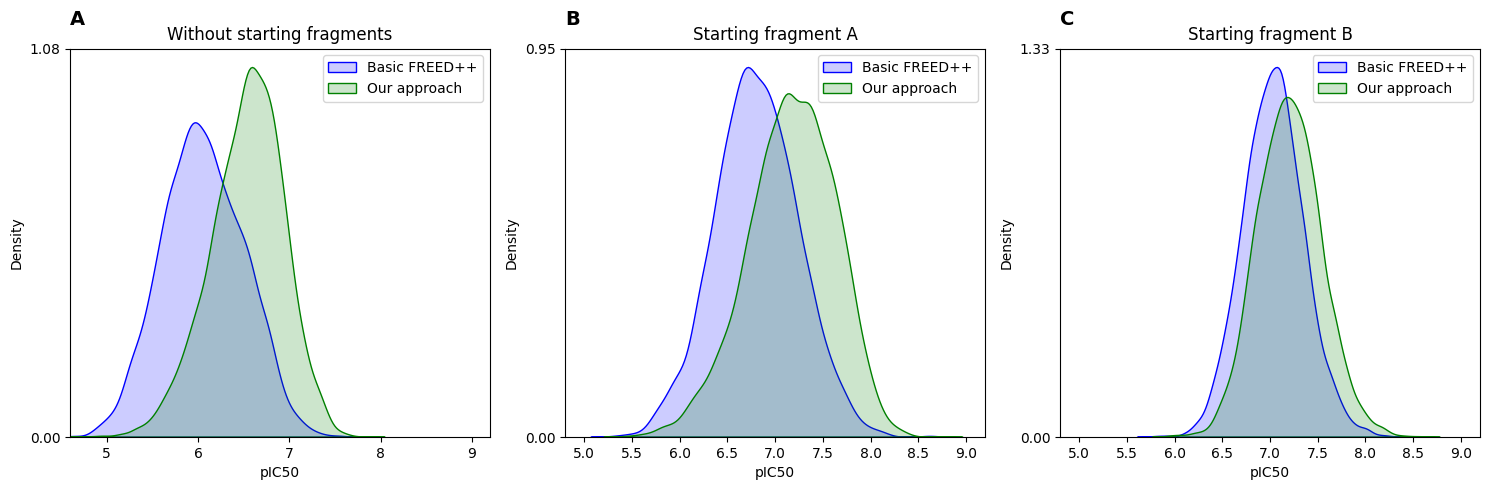

In [ ]:
colors = ['#ff9999', '#66b3ff', '#99ff99']

# Создаем фигуру с тремя графиками
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Первый график: сравнение 'Base model' и 'pIC50 reward'
sns.kdeplot(exp_1['pIC50'], fill=True, color="blue", alpha=0.2, label='Basic FREED++', ax=axes[0])
sns.kdeplot(exp_2['pIC50'], fill=True, color="green", alpha=0.2, label='Our approach', ax=axes[0])
axes[0].set_xlabel('pIC50')
axes[0].set_ylabel('Density')
axes[0].set_xlim(4.6, 9.2)
axes[0].legend()
set_min_max_ticks(axes[0])
axes[0].text(0, 1.1, 'A', transform=axes[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
axes[0].set_title('Without starting fragments', fontsize=12)

# Второй график: сравнение 'Starting fragment 1' и 'Starting fragment 1'
sns.kdeplot(exp_3['pIC50'], fill=True, color="blue", alpha=0.2, label='Basic FREED++', ax=axes[1])
sns.kdeplot(exp_4['pIC50'], fill=True, color="green", alpha=0.2, label='Our approach', ax=axes[1])
axes[1].set_xlabel('pIC50')
axes[1].set_ylabel('Density')
axes[1].set_xlim(4.8, 9.2)
axes[1].legend()
set_min_max_ticks(axes[1])
axes[1].text(0, 1.1, 'B', transform=axes[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
axes[1].set_title('Starting fragment A', fontsize=12)

# Третий график: сравнение 'Starting fragment 2' и 'Starting fragment 2'
sns.kdeplot(exp_5['pIC50'], fill=True, color="blue", alpha=0.2, label='Basic FREED++', ax=axes[2])
sns.kdeplot(exp_6['pIC50'], fill=True, color="green", alpha=0.2, label='Our approach', ax=axes[2])
axes[2].set_xlabel('pIC50')
axes[2].set_ylabel('Density')
axes[2].set_xlim(4.8, 9.2)
axes[2].legend()
set_min_max_ticks(axes[2])
axes[2].text(0, 1.1, 'C', transform=axes[2].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
axes[2].set_title('Starting fragment B', fontsize=12)

# Настройка расстояний между графиками
plt.tight_layout()

plt.savefig('Figure_4.jpg', format='jpg', dpi=1000, bbox_inches='tight')
plt.savefig('Figure_4.pdf', format='pdf', dpi=1000, bbox_inches='tight')


# Показать все графики на одной фигуре
plt.show()

# Final set of good molecules

In [ ]:
# Function for selecting molecules according to Evaluation metrics
def filter_dataframe(df):
    return df[(df['sascore'] < 6) &
              (df['lipinski_ro5'] == True) &
              (df['QED'] > 0.67) &
              (df['tox_groups'] == 0) &
              (df['pIC50'] > 7.4) &
              (df['DockingScoreProperty'] < -7)]

In [ ]:
good_mols_base = pd.DataFrame()
good_mols_ic50 = pd.DataFrame()

In [ ]:
for df in [exp_1, exp_3, exp_5]:
    filtered_df = filter_dataframe(df)
    good_mols_base = pd.concat([good_mols_base, filtered_df], ignore_index=True)

for df in [exp_2, exp_4, exp_6]:
    filtered_df = filter_dataframe(df)
    good_mols_ic50 = pd.concat([good_mols_ic50, filtered_df], ignore_index=True)

In [ ]:
print('The number of promising molecules obtained using the basic FREED++:', len(good_mols_base))

The number of promising molecules obtained using the basic FREED++: 69


In [ ]:
print('The number of promising molecules obtained using our approach:', len(good_mols_ic50))

The number of promising molecules obtained using our approach: 72


In [ ]:
good_mols = pd.concat([good_mols_ic50, good_mols_base], ignore_index=True)

In [ ]:
good_mols.drop_duplicates(subset='Smiles', inplace=True)

In [ ]:
print('Total number of selected molecules:', len(good_mols))

Total number of selected molecules: 139
